# Variational Inference: Spam Detection

In this assignment, we will load the UCI SMS Spam Collection dataset.
However, instead of using it directly, we will use fixed-size vector embeddings of the message.
Those embeddings have already been produced and are provided here to you.


## Setting the Scene

The goal of this assignment to go beyond a traditional classifier and apply variational methods.
This means that we will train a model using some parameters over the distribution of which we have a prior belief.
Our prior belief here is actually that each and every parameter independently follows a standard normal distribution.


During optimization, we will draw sets of parameters from our variational distribution $q_{\phi}$.
Drawing these parameters needs to be done using the reparameterization trick, so that we can add noise, i.e., $w_i=\mu_i+\sigma_i\cdot\epsilon$.
The assignment also poses one or the other question (clearly marked), you need to provide your answer directly after.


The assignment has some blank spots for you to fill out (but you can customize your implementation to your liking).
Training should be done using stochastic gradient descend, either using manual gradient updates or using an optimizer.

You should use autodiff-capabilities to compute gradients.
It is recommended to use, for example, JAX or PyTorch.
We recommend the latter, using it in a functional way (i.e., using `torch.func.jacrev`).
The blanks left in this assignment and their type hints assume PyTorch.
There are some cells with quick tests/sanity-checks, that you are free to remove, especially if they do not go along with how you chose to implement your solution.


At the end of the assignment, after training, you need to pick one advanced method of evaluation.
We are not interested in traditional metrics here (e.g., accuracy, Kappa, F1, etc.; although you are welcome to show those).
Rather, we want to exploit the variational nature of the model here and show something more interesting.

# Load the Data

You're variational model shall use no more than 15 components (aim for ~5 or fewer).
You'll have to apply a dimensionality reduction.

Sentence Embeddings were created in two ways:

1. (Recommended) Using [ALBERT XLarge v2](https://huggingface.co/albert/albert-xlarge-v2) (`albert-xlarge-v2`). Dim $=2,048$.
2. Using [English word vectors](https://fasttext.cc/docs/en/english-vectors.html) from `wiki-news-300d-1M` using `fasttext`. Dim $=300$.

In either case, the embeddings were averaged along the sequence dimension to produce fixed-size vectors.
In the provided dataset, the messages are retained.
This is useful should you choose a qualitative evaluation.

The labels have already been converted to floats: 0.0=ham, 1.0=spam.
The default example below shows a spam message.

In [ ]:

# Each data file contains 3 keys: X, y, msg
import numpy as np

data = np.load(file='2048d_sms_spam_albert-xlarge-v2.npz')
# data = np.load(file='300d_sms_spam_fasttext_pca.npz')

X: np.ndarray; Y: np.ndarray
X, Y, msg = data.get('X'), data.get('y'), data.get('msg')
X.shape, Y.shape, len(msg), msg[2], Y[2]

((5572, 2048),
 (5572,),
 5572,
 np.str_("Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"),
 np.int64(1))

# Define the Model

Our model is to be a polynomial with degree corresponding to the number of components chosen for the PCA.

$$
\begin{align}
    z=w_0+w_1\cdot x_1+w_2x_2^2+\dots+w_nx_n^n.
\end{align}
$$

We will perform a **binary** classification problem, using the binary cross-entropy (CE).
CE has a range of $[0,\infty)$.
The better the predictions of our model, the lower the CE.


Note that binary CE requires our predictions to be in the range $[0,1]$.
Therefore, we will have to pass its raw outputs ("logits") through the Sigmoid function.
This makes our model a **logistic** classifier.
The Sigmoid function is defined as $s(x)=\frac{1}{1+e^{-z}}$.

$$
\begin{align}
    p_i&=s(z_i),\;\text{convert our raw predictions to probabilities, then:}
    \\[1ex]
    \hat{y}_i&\sim\text{Bernoulli}(p_i).
\end{align}
$$


Since our predicted $\hat{y}$ will follow a Bernoulli distribution, we can directy use its likelihood function.
Note that maximizing the Bernoulli likelihood is equivalent of minimizing the binary CE!
The Bernoulli distribution is parameterized by a single parameter, **$p$**.


However, in our context, $p$ is unknown.
In order not to confuse the Bernoulli distribution's parameter $p$ with anything, in the following, we have substituted it with $s(z_i)$.
We will optimize for it, so that the output of our logisitic classifier becomes $p$.
The likelihood (for the prediction $\hat{y}_i$ of a single observation and its label $y_i$) then becomes:

$$
\begin{align}
    p(\mathbf{y}|\mathbf{X},\mathbf{w})&=\prod_i\,s(z_i)^{y_i}\cdot(1-s(z_i))^{1-y_i},
    \\
    \log{(p(\mathbf{y}|\mathbf{X},\mathbf{w}))}&=\sum_i\,\left[\log{(s(z_i)^{y_i})}+\log{((1-s(z_i))^{1-y_i})}\right],
    \\
    &=\sum_i\,\left[y_i\cdot\log{(s(z_i))} + (1-y_i)\cdot\log{(1-s(z_i))}\right].
\end{align}
$$

* Our **prior** belief is that each parameter follows a standard normal distribution, i.e., $w_j\sim\mathcal{N}(0,1)$.
* For our variational distribution, use a mean-field approximation of standard (independent) normals, too.


**Question**: Conceptually, how does the log-likelihood $p(y|x,w)$ compute its result given a single $n$-dimensional observation under the assumption of independent dimensions?

**Answer**: In case of independent dimensions, the (log-)likelihood across all dimensions is multiplied (summed).

# Implement the Model

Here, you are encouraged to use a library/framework like PyTorch or JAX and esp. functionality for automatic differentiation to compute gradients.
You may also import functions like `sigmoid` or `vmap` for vectorized operations.

It is recommended to implement vectorized versions of your required functions (i.e., batch-processing).

It is preferable to use type-hints for your functions.
Furthermore, you can write better code by inserting assertions (e.g., for dimensionality or other sanity-checks).
Please use Python-style comments like in the following:

```python
def func(w0: float, x: float) -> float:
    """
    Function to compute a multiple of x.
    """
    ...
```

In [2]:

import torch
from torch import Tensor

def model(w: Tensor, x: Tensor) -> Tensor:
    """
    Takes the coefficients w, the observations, computes the polynomial and
    returns probabilities.

    Compute: z = w₀ + w₁·x₁ + w₂·x₂² + w₃·x₃³ + ...
    Then: p = sigmoid(z)

    Args:
        w: shape (num_samples, degree+1) or (degree+1,)
        x: shape (batch_size, degree)
    Returns:
        probabilities: shape (num_samples, batch_size) or (batch_size,)
    """
    if w.dim() == 1:
        w = w.unsqueeze(0)
    num_samples, num_coeffs = w.shape
    batch_size, degree = x.shape
    assert num_coeffs == degree + 1, "Mismatch between coeffs and feature degree."

    device = x.device
    ones = torch.ones(batch_size, 1, device=device, dtype=x.dtype)
    powers = torch.arange(1, degree + 1, device=device, dtype=x.dtype)
    poly_features = torch.pow(x, powers)
    design_matrix = torch.cat([ones, poly_features], dim=1)

    logits = design_matrix @ w.T  # (batch_size, num_samples)
    probs = torch.sigmoid(logits).T  # (num_samples, batch_size)

    return probs.squeeze(0) if num_samples == 1 else probs

In [3]:
# Sanity-check, we should get 4 outputs if the model is correctly vectorized!
temp = model(w=torch.rand(size=(1,6)), x=torch.rand(size=(4,5)))
temp

tensor([0.7639, 0.6875, 0.6746, 0.6764])

## The Likelihood function

In [4]:
def log_lik(y_true: Tensor, y_hat: Tensor) -> Tensor:
    """
    For one or more observations, where y_true is the true label (0 or 1)
    and y_hat contains predicted probabilities [0,1], computes the (log)
    likelihood.
    Bernoulli log-likelihood:
    log p(y|ŷ) = Σ [y·log(ŷ) + (1-y)·log(1-ŷ)]
    """
    eps = torch.finfo(y_hat.dtype).eps
    probs = torch.clamp(y_hat, eps, 1.0 - eps)
    y = y_true.unsqueeze(0) if probs.dim() == 2 and y_true.dim() == 1 else y_true
    log_prob = y * torch.log(probs) + (1 - y) * torch.log(1 - probs)
    return log_prob.sum(dim=-1)

In [5]:
# Sanity-check, should be a single element here:
log_lik(y_true=torch.tensor(data=[1,0,1,0], dtype=torch.float), y_hat=temp)

tensor(-2.9544)

# The Evidence Lower BOund (ELBO)

Optimizing the ELBO (maximization) is the same as minimizing the KL divergence.
Here, the students shall implement a **Monte Carlo** approximation.

According to the slides, this is how it's done:

1. Sample from approximate posterior distribution $q_{\phi}(\theta)$.
    * Direct sampling methods should be used (we have a well-defined mean-field approximation here).
    * Apply reparameterization trick to train the model. Note: Do **not** use amortized variational inference here.
2. Estimate the ELBO using stochastic gradient-based optimization.

---------

Remember that the Bayesian framework tells us something about the *model*.
The variational approach allows us to **empirically** estimate the overall goodness of fit of our model.

In order to do that sufficiently well, we need more than just point estimates.
Recall that we do **not** attempt to find some best point estimates for our data, but rather a distribution over them.
In order for that to work well, we need to test many different parameter constellations and average over those results.
In other words, we need to draw many different sets of possible variational distribution parameters and check how well these allow our model, on average, to predict the constant observations.


-------

Recall the definition of the ELBO:

$$
\begin{align}
    \text{ELBO}&=\mathbb{E}_{q_{\phi}(\mathbf{w})}\left[\log{(p(\mathbf{y}|\mathbf{X},\mathbf{w}))}\right]-D_{\text{KL}}\left(q_{\phi}(\mathbf{w})\|p(\mathbf{w})\right).
\end{align}
$$

-------

For simplicity here, assume there will be the following "loops":

1. Outermost loop is governed by the epoch ($E$).
2. The next loop is over the stochastic mini-batches of observations (batches of size $N$).
    * For each batch, you draw $w^{(s)}\in 1\dots S$ **new** different sets of parameter configurations from your variational distribution.
    * Here, you'll be using the reparameterization trick.
3. Loop over $S$:
    * (a) For each configuration $s_i$, you will have to multiply (sum) the (log) likelihood of each observation under the current likelihood function (as parameterized by $w^{(s)}$).
    * (b) Next, calculate the KL-divergence between our approximate posterior (the mean-field approximation of independent Gaussians) and our prior (which is a diagonal standard normal distribution). **Attention**:
        * You use either, the **analytical** or the **Monte Carlo** approximation of the KL-divergence. However, the analytical one is essentially *outside the expectation* (because it does not average over $w^{(s)}$), whereas the MC-approximation should perhaps be an addend/subtrahend to (a).
        * In effect, the analytical KL-divergence is calculated only **once** per batch, using the **current** variational parameters (i.e., as they were after the last optimizer's step or after initialization for first step).
    * Calculate (a) - (b), according to previous remark.
4. Average the results from step 3 (considering the remark about analytical/MC version of the KL-divergence). It needs to be an average because the ELBO is an expectation (a weighted mean) over all possible realizations of $s_i\in S$. For each individual batch, you have now an average idea of:
    * The *expected* data likelihood.
    * How strongly your prior and approximate posterior diverge from one another.
5. Do not accumulate results across batches at this point.
    * It is better to compute a gradient for each batch and apply parameter updates. Frequent, incremental updates work better in practice.


**Notes**:
* As $S$ approaches $\infty$, the MC-approximation of the KL-divergence will be equal to the analytical solution.
* For the MC-approximation, a good $S$ is perhaps $50-500$.

# Putting it all together

Let's implement the "loops" from above.
We will create stochastic mini-batches of our data to compute gradients on.
For now, we will not implement a loop for epochs.

The ELBO for a list of parameters sets $S$ and a mini-batch of length $N$ is defined as follows:

$$
\begin{align}
    \text{ELBO}(\phi)&\approx\left(\frac{1}{S}\sum_{s=1}^{S}\,\underbrace{\left[\sum_{i=1}^{N}\,\log{(p(y_i|x_i,w^{(s)}))}\right]}_{\text{log-sum of i.i.d. observations}}\right)-\underbrace{D_{\text{KL}}(q_{\mu,\sigma}(w)\|p(w))}_{\text{using the current $\mu,\sigma$}}.
    \\[4em]
    \text{Also note that}&\text{ we can use Monte Carlo to approximate the KL-divergence:}\nonumber
    \\[1em]
    D_{\text{KL}}(q_{\mu,\sigma}(w)\|p(w))&=\mathbb{E}_{w\sim q_{\mu,\sigma}(w)}\left[\log{\left(\frac{q_{\mu,\sigma}(w)}{p(w)}\right)}\right],
    \\[1em]
    &=\frac{1}{S}\sum_{s=1}^{S}\,\left[\log{\left(q_{\mu,\sigma}\left(w^{(s)}\right)\right)}-\log{\left(p\left(w^{(s)}\right)\right)}\right].
    \\[2em]
    \text{Also note that}&\text{ the KL-divergence between two normals has an analytical solution:}\nonumber
    \\[1em]
    D_{\text{KL}}(q_{\mu,\sigma}(w)\|\mathcal{N}(0,I))&=\frac{1}{2}\sum_{j=0}\,\left(\mu_j^2+\sigma_j^2-1-\log{\left(\sigma_j^2\right)}\right).
    \\[2em]
    \text{Also note that}&\text{ the ELBO including the MC-approximation of the KL-divergence is:}\nonumber
    \\[1em]
    \text{ELBO}(\phi)&\approx\frac{1}{S}\sum_{s=1}^{S}\,\underbrace{\left[\sum_{i=1}^{N}\,\log{(p(y_i|x_i,w^{(s)}))}\right]}_{\text{log-sum of i.i.d. observations}}-\underbrace{\left[\log{\left(q_{\mu,\sigma}\left(w^{(s)}\right)\right)}-\log{\left(p\left(w^{(s)}\right)\right)}\right]}_{\text{MC-approx. of KL-divergence}}.
\end{align}
$$

# Implementation

Here, implement everything you need.

## Data Preparation and Dimensionality Reduction

Start by reducing the dimensionality of your data.
Choose a combination of dataset and polynomial degree that is not too low and not too high.
Aim for at least 30% explained variance and at most 15 components.

Report the (sum of the) explained variance before you proceed.


Remember the basics: splitting, randomness, scaling, etc.

Explained total variance by 4 (sum %): 37.58
Per-component variance (%): [22.40649    7.1478114  4.6546707  3.3759751]


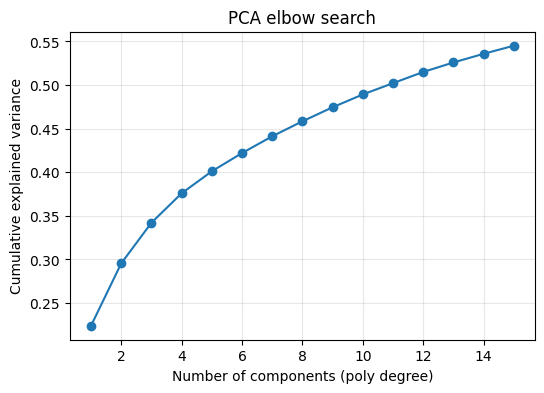

Training set shape: torch.Size([4457, 4])
Test set shape: torch.Size([1115, 4])


In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

POLY_DEGREE = 4


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=POLY_DEGREE, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



explained_var = pca.explained_variance_ratio_.sum() * 100
print(f"Explained total variance by {POLY_DEGREE} (sum %): {explained_var:.2f}")
print("Per-component variance (%):", pca.explained_variance_ratio_ * 100)


def plot_pca_elbow(X: np.ndarray, max_components: int = 15) -> None:
    explained = []
    dims = range(1, max_components + 1)
    for k in dims:
        reducer = PCA(n_components=k, random_state=42)
        reducer.fit(X)
        explained.append(reducer.explained_variance_ratio_.sum())
    plt.figure(figsize=(6, 4))
    plt.plot(list(dims), explained, marker="o")
    plt.xlabel("Number of components (poly degree)")
    plt.ylabel("Cumulative explained variance")
    plt.title("PCA elbow search")
    plt.grid(alpha=0.3)
    plt.show()

plot_pca_elbow(X_train_scaled, max_components=15)

X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# train_ds = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# test_ds = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
# train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
# test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


print(f"Training set shape: {X_train_tensor.shape}")
print(f"Test set shape: {X_test_tensor.shape}")

## Model

Below you'll find some prototypes (fill in the blanks).
Again, this is just a suggestion, you can come up with your own implementation.

In [42]:
def ELBO_expected_data_likelihood(y_true: Tensor, x: Tensor, W: Tensor) -> Tensor:
    """A function to calculate the first term of the ELBO.
    E_q[log p(y|X,w)] ≈ (1/S) Σₛ log p(y|X,w⁽ˢ⁾)
    """
    assert W.dim() == 2, "Expected W with shape (num_samples, degree+1)."
    probs = model(W, x)                      # (num_samples, batch_size)
    log_probs = log_lik(y_true, probs)       # (num_samples,)
    return log_probs.mean()


def ELBO_KL_divergence_analytical(mu: Tensor, sigma: Tensor) -> Tensor:
    """The analytical version of the KL divergence.
    KL(N(μ,σ²) || N(0,1)) = (1/2) Σⱼ [μⱼ² + σⱼ² - 1 - log(σⱼ²)]
    """
    eps = torch.finfo(sigma.dtype).eps
    sigma_sq = sigma.pow(2)
    return 0.5 * torch.sum(mu.pow(2) + sigma_sq - 1 - torch.log(sigma_sq + eps))


def ELBO_KL_divergence_Monte_Carlo(W: Tensor, mu: Tensor, sigma: Tensor) -> Tensor:
    """
    The Monte Carlo approximation of the KL divergence.
    You don't need to implement both, one is enough.
    KL(q||p) ≈ (1/S) Σₛ [log q(w⁽ˢ⁾) - log p(w⁽ˢ⁾)]
    """
    assert W.dim() == 2, "W must be shaped (num_samples, num_params)."
    assert mu.shape == sigma.shape == (W.size(1),), "mu and sigma must match parameter dimension."

    sigma_sq = sigma.pow(2)
    log_q = -0.5 * (((W - mu) ** 2) / sigma_sq + torch.log(2 * torch.pi * sigma_sq)).sum(dim=1)
    log_p = -0.5 * (W.pow(2) + torch.log(2 * torch.pi * torch.ones_like(W))).sum(dim=1)

    return (log_q - log_p).mean()

In [43]:
from typing import Literal
from torch import autograd

NUM_VARIATIONAL_SETS = 50
KL_DIV_TYPE = Literal['analytical', 'montecarlo']


def ELBO(use_mu: Tensor, use_sigma: Tensor, y_true: Tensor, obs: Tensor, variational_params_noise: Tensor, kl: KL_DIV_TYPE='analytical', return_exp_data_lik: bool=False, return_kl_div: bool=False) -> Tensor|tuple[Tensor, ...]:
    """
    Convenience function that uses the current variational parameters,
    applies the reparameterization trick, and computes the complete
    ELBO. The result of this function shall be maximized.

    ELBO = E[log p(y|X,w)] - KL(q||p)
    """
    assert use_mu.shape == use_sigma.shape, "mu and sigma must share the same shape."
    assert variational_params_noise.shape == (NUM_VARIATIONAL_SETS, use_mu.numel()), (
        "Noise must be shaped (S, D) where D is number of coefficients."
    )

    W = use_mu + use_sigma * variational_params_noise  # reparameterization
    exp_log_lik = ELBO_expected_data_likelihood(y_true=y_true, x=obs, W=W)

    if kl == 'analytical':
        kl_div = ELBO_KL_divergence_analytical(use_mu.flatten(), use_sigma.flatten())
    elif kl == 'montecarlo':
        kl_div = ELBO_KL_divergence_Monte_Carlo(W=W, mu=use_mu.flatten(), sigma=use_sigma.flatten())
    else:
        raise ValueError(f"Unknown KL type: {kl}")

    elbo = exp_log_lik - kl_div

    outputs: list[Tensor] = [elbo]
    if return_exp_data_lik:
        outputs.append(exp_log_lik)
    if return_kl_div:
        outputs.append(kl_div)

    return tuple(outputs) if len(outputs) > 1 else elbo

def ELBO_scalar(
    use_mu,
    use_sigma,
    y_true,
    obs,
    variational_params_noise,
    kl='analytical',
):
    # Always returns ONLY the scalar ELBO
    return ELBO(
        use_mu=use_mu,
        use_sigma=use_sigma,
        y_true=y_true,
        obs=obs,
        variational_params_noise=variational_params_noise,
        kl=kl,
        return_exp_data_lik=False,
        return_kl_div=False,
    )

# TODO: Define/create the gradient of the ELBO function.
ELBO_grad = torch.func.grad(ELBO_scalar, argnums=(0, 1))

# Training

Train your model until convergence.
Choose a number of iterations, batch-size, and learning rate that make sense in your scenario.
Do not perform a grid search or other hyperparameter optimization.
Instead, manually find some good working parameters and make your final solution just use these.


* **Plot** the training curve (i.e., plot the history for each component of the ELBO).
* **Print** the final parameters for your variational distribution after optimization.
* **Evaluate** the ELBO on the holdout dataset. Is it close? You could also do this during training.

Epoch 000: Train ELBO=-217.2751, ExpLogLik=-215.6501, KL=1.6250, Test ELBO (full set)=-8807.5020
Epoch 010: Train ELBO=-195.4442, ExpLogLik=-193.6955, KL=1.7486, Test ELBO (full set)=-7506.0312
Epoch 020: Train ELBO=-184.2345, ExpLogLik=-182.3186, KL=1.9159, Test ELBO (full set)=-6577.1001
Epoch 030: Train ELBO=-172.3473, ExpLogLik=-170.2359, KL=2.1114, Test ELBO (full set)=-5244.5063
Epoch 040: Train ELBO=-160.8094, ExpLogLik=-158.4666, KL=2.3428, Test ELBO (full set)=-5584.4453
Epoch 050: Train ELBO=-147.1075, ExpLogLik=-144.5093, KL=2.5982, Test ELBO (full set)=-4594.5718
Epoch 060: Train ELBO=-133.4013, ExpLogLik=-130.5694, KL=2.8319, Test ELBO (full set)=-5165.5767
Epoch 070: Train ELBO=-124.2332, ExpLogLik=-121.1969, KL=3.0363, Test ELBO (full set)=-4246.5098
Epoch 080: Train ELBO=-118.5066, ExpLogLik=-115.3313, KL=3.1753, Test ELBO (full set)=-3860.3699
Epoch 090: Train ELBO=-114.3043, ExpLogLik=-111.0111, KL=3.2932, Test ELBO (full set)=-4086.8701
Epoch 100: Train ELBO=-111.470

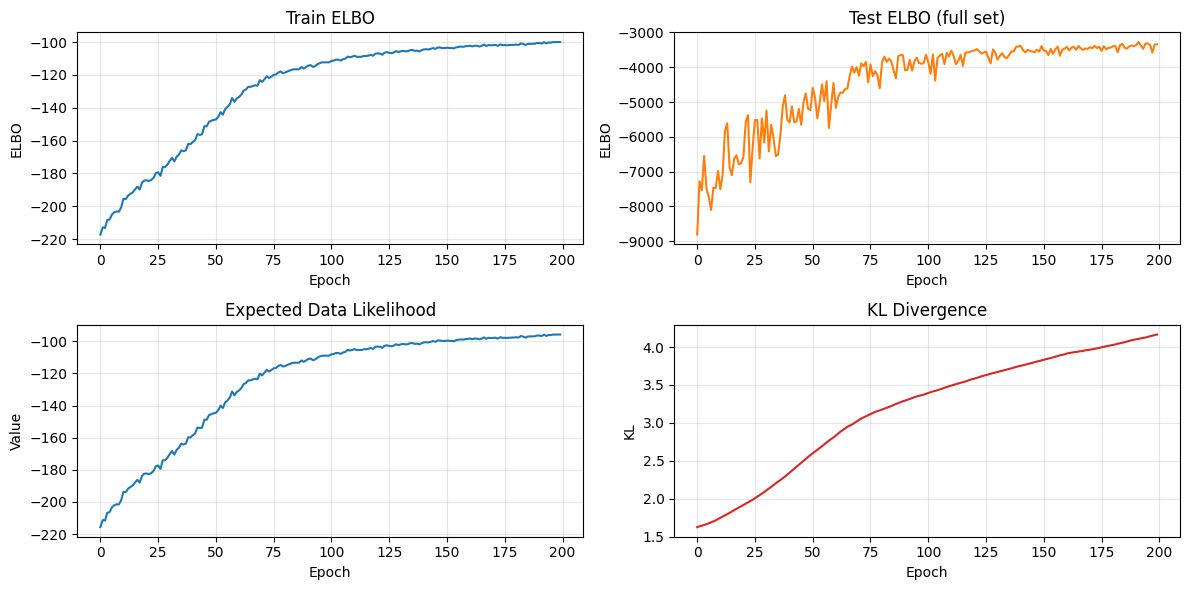

In [44]:
# TODO: Implement as however you require this!
# TODO: Make sure to use the finally found optimal parameters once you submit your solution.
USE_KL_TYPE: KL_DIV_TYPE = "analytical"

# Hyperparameters
NUM_VARIATIONAL_SETS = 50
EPOCHS = 200
LEARNING_RATE = 1e-4
BATCH_SIZE = 32

# Number of parameters = degree + 1 (bias + polynomial coefficients)
n_params = POLY_DEGREE + 1

# ---- Variational parameters (what we optimize!) ----
# small random μ, σ ≈ 0.5
mu = (0.1 * torch.randn(n_params)).requires_grad_()                 # ~ N(0, 0.1²)
log_sigma = torch.log(0.5 * torch.ones(n_params)).requires_grad_()  # σ ≈ 0.5

# Optimizer
optimizer = torch.optim.Adam([mu, log_sigma], lr=LEARNING_RATE)

# History for plotting
history = {
    "elbo": [],
    "exp_log_lik": [],
    "kl_div": [],
    "test_elbo": [],  # evaluated on full test set
}

num_samples = X_train_tensor.size(0)
num_batches = (num_samples + BATCH_SIZE - 1) // BATCH_SIZE

for epoch in range(EPOCHS):
    # ---- Training epoch ----
    perm = torch.randperm(num_samples)
    X_shuffled = X_train_tensor[perm]
    y_shuffled = y_train_tensor[perm]

    epoch_elbo = 0.0
    epoch_exp_log_lik = 0.0
    epoch_kl_div = 0.0
    batch_counter = 0

    for batch_idx in range(num_batches):
        start = batch_idx * BATCH_SIZE
        end = min(start + BATCH_SIZE, num_samples)
        if start >= num_samples:
            break

        x_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]
        if x_batch.numel() == 0:
            continue

        # Sample S weight sets using reparameterization
        noise = torch.randn(NUM_VARIATIONAL_SETS, n_params)
        sigma = torch.exp(log_sigma)

        elbo_val, exp_log_lik, kl_div = ELBO(
            use_mu=mu,
            use_sigma=sigma,
            y_true=y_batch,
            obs=x_batch,
            variational_params_noise=noise,
            kl=USE_KL_TYPE,
            return_exp_data_lik=True,
            return_kl_div=True,
        )

        loss = -elbo_val  # maximize ELBO <=> minimize -ELBO

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_elbo += elbo_val.item()
        epoch_exp_log_lik += exp_log_lik.item()
        epoch_kl_div += kl_div.item()
        batch_counter += 1

    # Average over batches (train metrics)
    epoch_elbo /= batch_counter
    epoch_exp_log_lik /= batch_counter
    epoch_kl_div /= batch_counter
    history["elbo"].append(epoch_elbo)
    history["exp_log_lik"].append(epoch_exp_log_lik)
    history["kl_div"].append(epoch_kl_div)

    # ---- Evaluation on entire test set (no_grad) ----
    with torch.no_grad():
        sigma_eval = torch.exp(log_sigma)
        noise_eval = torch.randn(NUM_VARIATIONAL_SETS, n_params)

        # one ELBO over the full test set
        test_elbo = ELBO(
            use_mu=mu,
            use_sigma=sigma_eval,
            y_true=y_test_tensor,
            obs=X_test_tensor,
            variational_params_noise=noise_eval,
            kl=USE_KL_TYPE,
        )
        history["test_elbo"].append(test_elbo.item())

    # Print every 10 epochs + last
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(
            f"Epoch {epoch:03d}: "
            f"Train ELBO={epoch_elbo:.4f}, "
            f"ExpLogLik={epoch_exp_log_lik:.4f}, "
            f"KL={epoch_kl_div:.4f}, "
            f"Test ELBO (full set)={history['test_elbo'][-1]:.4f}"
        )


def plot_elbo_curves(history: dict[str, list[float]]) -> None:
    """More readable plots: separate Train/Test ELBO and components."""
    epochs = np.arange(len(history["elbo"]))

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))

    # (0, 0) Train ELBO
    ax = axes[0, 0]
    ax.plot(epochs, history["elbo"], label="Train ELBO")
    ax.set_title("Train ELBO")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("ELBO")
    ax.grid(alpha=0.3)

    # (0, 1) Test ELBO (full set)
    ax = axes[0, 1]
    ax.plot(epochs, history["test_elbo"], label="Test ELBO (full set)", color="tab:orange")
    ax.set_title("Test ELBO (full set)")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("ELBO")
    ax.grid(alpha=0.3)

    # (1, 0) Expected Data Likelihood
    ax = axes[1, 0]
    ax.plot(epochs, history["exp_log_lik"], label="E[log p(y|X,w)]")
    ax.set_title("Expected Data Likelihood")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.grid(alpha=0.3)

    # (1, 1) KL Divergence
    ax = axes[1, 1]
    ax.plot(epochs, history["kl_div"], label="KL(q||p)", color="tab:red")
    ax.set_title("KL Divergence")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("KL")
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()



with torch.no_grad():
    sigma_eval = torch.exp(log_sigma)
    noise_eval = torch.randn(NUM_VARIATIONAL_SETS, n_params)
    full_test_elbo = ELBO(
        mu, sigma_eval, y_test_tensor, X_test_tensor,
        noise_eval, kl=USE_KL_TYPE
    )
    elbo_per_point = full_test_elbo.item() / len(y_test_tensor)
    final_mu = mu.detach()
    final_sigma = torch.exp(log_sigma.detach())

print("\nFinal test ELBO (full set):", full_test_elbo.item())
print("Final test ELBO per data point:", elbo_per_point)
print("\nFinal variational parameters:")
print(f"μ = {final_mu.numpy()}")
print(f"σ = {final_sigma.numpy()}")



plot_elbo_curves(history)


# Advanced Model Evaluation (Pick <u>One</u>)

In this last part of the assignment, you should select **exactly one** of the following evaluation procedures.
Your task is to implement your chosen evaluation fully and clearly, produce within your notebook at least **one informative visualization**, and **provide a 100–500 word explanation** presenting:

- **Motivation:** Why you selected this particular evaluation.
- **Implementation:** How exactly your approach was implemented (with brief explanations for your visualization and choice of metrics).
- **Insights:** What interesting facts, strengths, or weaknesses were revealed from applying this evaluation.

-----

Pick one of the following:


1. **Visualization of Learned Low-dimensional Representations**
    * Visualize embeddings from your variational polynomial model using dimensionality reduction (e.g., PCA, t-SNE, UMAP).
    * Color embeddings by posterior uncertainty estimates or predictions.
    * This illustrates nicely how your model's uncertainty varies across regions of your feature space.
2. **Posterior Predictive Checks (PPC) (Visualizations of uncertainty)**
    * Posterior predictive checks evaluate your model by extending its sampled posterior parameters forward into the data space, then comparing the simulated data (from the posterior) with the real observed data.
3. **Evaluation of the ELBO on Hold-out Data and Bayesian (Probabilistic) Performance Metrics**
    * Evaluate the quality of your approximate posterior by evaluating ELBO on the hold-out set.
    * Bayesian performance metrics, for example: Log Predictive Density (LPD) and Bayesian Information Criterion (BIC)
4. **Posterior Weight Visualization**
    * Examine posterior distributions of your parameters (coefficients of your polynomial regression).
5. **Out-of-Distribution (OoD) Detection Capability incl. Likelihood-Based Evaluation (Density Estimation Quality)**
    * E.g., generate data points far away from the hold-out dataset and evaluate likelihood, uncertainty, etc.
    * Compare computed likelihood of the train- and hold-out dataset.
6. **Expected Calibration Error (ECE) and Calibration Curves (Reliability Diagrams)**
    * Expected Calibration Error numerically summarizes the calibration curves, giving you a single statistic to quantify how good or poor calibration of a model is.
7. **Latent Space Smoothness and Structure**
    * Generate intermediate points (linear interpolation) between latent variables from spam and non-spam messages and decode these embeddings. Good generative models produce semantically smooth interpolations.
8. **Qualitative Evaluation of a few messages**
    * Pick about ~10 messages from the holdout dataset. Among those 10, you should have some that are obviously spam, some that are ambiguous, and some that are clearly ham.
    * Evaluate the model's predictions and uncertainty about these predictions. Is there a scheme that materializes here?

Qualitative Evaluation of Spam Detection Model

Message 1: ✓ [SPAM] - Prediction: 0.680 ± 0.465 (LOW confidence)
Text: "U dun say so early hor... U c already then say..."

Message 2: ✓ [SPAM] - Prediction: 0.511 ± 0.499 (LOW confidence)
Text: "There is os called ubandu which will run without installing in hard disk...you can use that os to co..."

Message 3: ✓ [SPAM] - Prediction: 0.642 ± 0.477 (LOW confidence)
Text: "PLEASSSSSSSEEEEEE TEL ME V AVENT DONE SPORTSx"

Message 4: ✓ [SPAM] - Prediction: 0.642 ± 0.478 (LOW confidence)
Text: "Waiting for your call."

Message 5: ✓ [HAM] - Prediction: 0.000 ± 0.000 (HIGH confidence)
Text: "Ok give me 5 minutes I think I see her. BTW you're my alibi. You were cutting my hair the whole time..."

Message 6: ✓ [HAM] - Prediction: 0.000 ± 0.000 (HIGH confidence)
Text: "My sister in law, hope you are having a great month. Just saying hey. Abiola"

Message 7: ✓ [HAM] - Prediction: 0.000 ± 0.000 (HIGH confidence)
Text: "Will purchase d stuff today and 

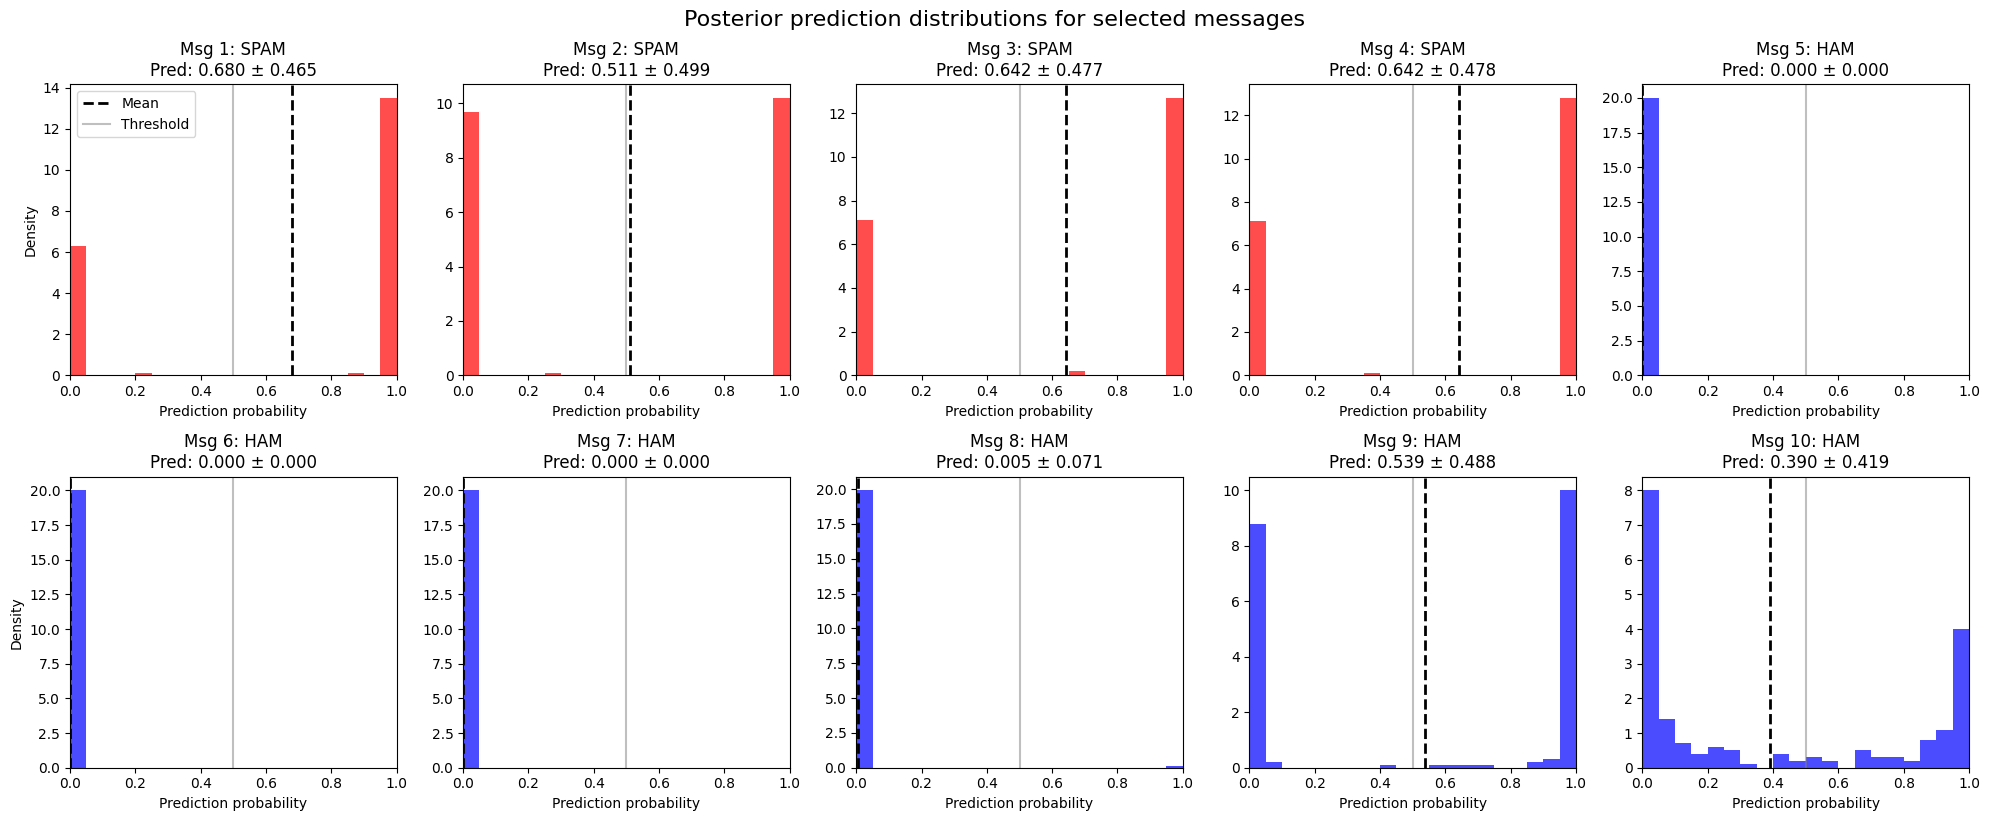

SUMMARY ANALYSIS
Accuracy on selected messages: 90.0% (9/10)
Average uncertainty for SPAM messages: 0.480
Average uncertainty for HAM messages:  0.163

Most confident prediction (σ=0.000):
  "Ok give me 5 minutes I think I see her. BTW you're my alibi. You were cutting my..."
  True: HAM, Predicted mean: 0.000

Least confident prediction (σ=0.499):
  "There is os called ubandu which will run without installing in hard disk...you c..."
  True: SPAM, Predicted mean: 0.511

Pattern: Higher uncertainty appears on more ambiguous messages (near the 0.5 threshold).


In [46]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ---------- Config for qualitative eval ----------
N_WEIGHT_SAMPLES = 200      # posterior samples per message
N_MESSAGES = 10             # total messages to inspect
N_CLEAR_SPAM = 4
N_CLEAR_HAM = 4
N_AMBIGUOUS = 2
THRESH = 0.5                # classification threshold


# ---------- 1. Helper: posterior predictive for ONE message ----------
def get_predictions_with_uncertainty(x_sample: torch.Tensor,
                                     mu: torch.Tensor,
                                     log_sigma: torch.Tensor,
                                     n_samples: int = N_WEIGHT_SAMPLES):
    """
    For a single feature vector x_sample, draw n_samples of weights w ~ q(w)
    and return:
        - mean predicted probability
        - std of predicted probability
        - all individual samples (for plotting a histogram)
    """
    sigma = torch.exp(log_sigma)
    preds = []

    with torch.no_grad():
        for _ in range(n_samples):
            noise = torch.randn_like(mu)
            w_sample = mu + sigma * noise              # (D,)
            p = model(w_sample.unsqueeze(0),           # (1, D)
                      x_sample.unsqueeze(0))           # (1, D) -> shape (1, 1)
            preds.append(p.item())

    preds = np.asarray(preds)
    return preds.mean(), preds.std(), preds


# ---------- 2. Choose 10 interesting test messages ----------
# Use the posterior MEAN weights to get a single "deterministic"
# probability for each test message, then use that to pick:
#   - very clear spam (high p)
#   - very clear ham (low p)
#   - ambiguous (p close to 0.5)

with torch.no_grad():
    # Posterior mean weights as point estimate
    probs = model(mu.unsqueeze(0), X_test_tensor)  # could be (N_test,) or (1, N_test)

    # Make sure it's a 1D tensor of length N_test
    if probs.dim() == 2:
        # e.g. shape (1, N_test)
        probs = probs[0]
    mean_probs = probs.detach().cpu().numpy().reshape(-1)  # (N_test,)

y_test_np = y_test_tensor.cpu().numpy()

spam_idx = np.where(y_test_np == 1)[0]
ham_idx = np.where(y_test_np == 0)[0]

# Clear spam: highest predicted probabilities among spam
clear_spam_idx = spam_idx[np.argsort(-mean_probs[spam_idx])[:N_CLEAR_SPAM]]

# Clear ham: lowest predicted probabilities among ham
clear_ham_idx = ham_idx[np.argsort(mean_probs[ham_idx])[:N_CLEAR_HAM]]

# Ambiguous: closest to 0.5 (regardless of label)
amb_idx_candidates = np.argsort(np.abs(mean_probs - 0.5))
amb_idx = []
for idx in amb_idx_candidates:
    if idx not in clear_spam_idx and idx not in clear_ham_idx:
        amb_idx.append(idx)
    if len(amb_idx) == N_AMBIGUOUS:
        break

selected_indices = list(dict.fromkeys(
    list(clear_spam_idx) + list(clear_ham_idx) + list(amb_idx)
))  # deduplicate while keeping order

assert len(selected_indices) == N_MESSAGES, "Did not collect 10 unique indices."

print("Qualitative Evaluation of Spam Detection Model")
print("=" * 60)
print()

results = []

for i, test_idx in enumerate(selected_indices):
    true_label = y_test_tensor[test_idx].item()
    x_sample = X_test_tensor[test_idx]

    # If msg is aligned with X (same order), this index works directly.
    message_text = msg[test_idx]

    # Posterior predictive for this one message
    pred_mean, pred_std, pred_samples = get_predictions_with_uncertainty(
        x_sample, mu, log_sigma, n_samples=N_WEIGHT_SAMPLES
    )

    results.append({
        "index": i + 1,
        "message": message_text,
        "true_label": true_label,
        "pred_mean": pred_mean,
        "pred_std": pred_std,
        "pred_samples": pred_samples,
    })

    label_str = "SPAM" if true_label == 1 else "HAM"
    confidence = (
        "HIGH" if pred_std < 0.10
        else "MEDIUM" if pred_std < 0.20
        else "LOW"
    )
    correct = "✓" if (pred_mean > THRESH) == (true_label == 1) else "✗"

    print(
        f"Message {i+1}: {correct} [{label_str}] "
        f"- Prediction: {pred_mean:.3f} ± {pred_std:.3f} ({confidence} confidence)"
    )
    print(f'Text: "{message_text[:100]}{"..." if len(message_text) > 100 else ""}"')
    print()


# ---------- 3. Visualise prediction distributions ----------
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, r in enumerate(results):
    ax = axes[i]

    ax.hist(
        r["pred_samples"],
        bins=20,
        alpha=0.7,
        density=True,
        color="red" if r["true_label"] == 1 else "blue",
    )
    ax.axvline(r["pred_mean"], color="black", linestyle="--", linewidth=2, label="Mean")
    ax.axvline(THRESH, color="gray", linestyle="-", alpha=0.5, label="Threshold")

    ax.set_xlim(0, 1)
    ax.set_title(
        f"Msg {i+1}: {'SPAM' if r['true_label'] == 1 else 'HAM'}\n"
        f"Pred: {r['pred_mean']:.3f} ± {r['pred_std']:.3f}"
    )
    ax.set_xlabel("Prediction probability")
    if i % 5 == 0:
        ax.set_ylabel("Density")
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("Posterior prediction distributions for selected messages", y=1.02, fontsize=16)
plt.show()


# ---------- 4. Summary analysis ----------
print("SUMMARY ANALYSIS")
print("=" * 60)

correct_predictions = sum(
    (r["pred_mean"] > THRESH) == (r["true_label"] == 1) for r in results
)
accuracy = correct_predictions / len(results)

spam_unc = [r["pred_std"] for r in results if r["true_label"] == 1]
ham_unc = [r["pred_std"] for r in results if r["true_label"] == 0]

print(f"Accuracy on selected messages: {accuracy:.1%} ({correct_predictions}/{len(results)})")
print(f"Average uncertainty for SPAM messages: {np.mean(spam_unc):.3f}")
print(f"Average uncertainty for HAM messages:  {np.mean(ham_unc):.3f}")

most_conf = min(results, key=lambda r: r["pred_std"])
least_conf = max(results, key=lambda r: r["pred_std"])

print(f"\nMost confident prediction (σ={most_conf['pred_std']:.3f}):")
print(f'  "{most_conf["message"][:80]}..."')
print(
    f"  True: {'SPAM' if most_conf['true_label'] == 1 else 'HAM'}, "
    f"Predicted mean: {most_conf['pred_mean']:.3f}"
)

print(f"\nLeast confident prediction (σ={least_conf['pred_std']:.3f}):")
print(f'  "{least_conf["message"][:80]}..."')
print(
    f"  True: {'SPAM' if least_conf['true_label'] == 1 else 'HAM'}, "
    f"Predicted mean: {least_conf['pred_mean']:.3f}"
)

if max(r["pred_std"] for r in results) > 0.2:
    print("\nPattern: Higher uncertainty appears on more ambiguous messages (near the 0.5 threshold).")
else:
    print("\nPattern: Model is generally very confident on the selected messages.")


### Motivation

I chose this qualitative evaluation because I wanted to see *how* the Bayesian spam model behaves on real messages, not just look at one number like accuracy. In spam detection, a wrong but very confident decision can be a big problem (for example, marking an important message as spam). By checking both the predictions and the uncertainty, we can see when the model is really sure and when it is basically saying “I’m not very confident about this”.

### Implementation

I worked with 10 messages from the test set: 4 that look clearly like spam, 4 clearly ham, and 2 that are more borderline. First, I used the posterior mean weights to get a single predicted spam probability for each test message, and used that to pick the “clear” and “ambiguous” examples (near the 0.5 decision threshold). Then, for each of these 10 messages, I sampled 200 different weight vectors from the learned Gaussian posterior (defined by the learned mean `mu` and standard deviation `sigma`). For every sampled weight vector I computed the spam probability, so I got a whole distribution of predictions instead of just one value. I summarized this distribution with the mean and standard deviation, plotted histograms with the mean and the 0.5 threshold marked, and calculated accuracy on these 10 messages plus the average uncertainty (standard deviation) for spam vs ham.

### Insights

On these 10 messages, the model got 9 out of 10 correct (90% accuracy). For clear ham messages, the predicted spam probability is almost 0 with a very small standard deviation, which means the model is very confident and also correct. For spam and more ambiguous messages, the mean probability is higher (around or above 0.5) but the standard deviation is large, showing that different sampled models often disagree. The only mistake is a ham message with a prediction just above 0.5 and very high uncertainty, which is exactly the kind of case where we would not fully trust the model’s decision. Overall, this suggests the model is good at saying “this is definitely ham”, but much less certain about spammy or borderline texts, which makes sense given the simple PCA-based features and polynomial model we are using.
